# Project: **Finding Lane Lines on the Road** 

## Import Packages

In [89]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


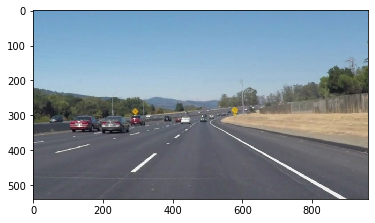

In [90]:
import os

image = []
image.append(mpimg.imread('test_images/solidWhiteCurve.jpg'))
image.append(mpimg.imread('test_images/solidWhiteRight.jpg'))
image.append(mpimg.imread('test_images/solidYellowCurve.jpg'))
image.append(mpimg.imread('test_images/solidYellowCurve2.jpg'))
image.append(mpimg.imread('test_images/solidYellowLeft.jpg'))
image.append(mpimg.imread('test_images/whiteCarLaneSwitch.jpg'))

#printing out some stats and plotting
for img in image:
    print('This image is:', type(img), 'with dimensions:', img.shape)

plt.imshow(image[0])

## Line detection pipeline

### Grayscale conversion

In [91]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

### Gaussian smoothing

In [92]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

### Canny Edges

In [93]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

### Mask

In [94]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
 
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Hough Transform

In [95]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

### Lines

In [107]:
def drawLines(img, lines):
    lm = []
    rm = []
    lc = []
    rc = []
    r_center = []
    l_center = []
    rcx = []
    rcy = []
    lcx = []
    lcy = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            x_center = (x1+x2)/2
            y_center = (y1+y2)/2
            if slope > 0:
                rm.append(slope)
                rcx.append(x_center)
                rcy.append(y_center)
            else:
                lm.append(slope)
                lcx.append(x_center)
                lcy.append(y_center)

    if (len(rm) > 1) & (len(lm) > 1):
        r_slope = np.sum(rm)/len(rm)
        l_slope = np.sum(lm)/len(lm)

        r_center_x = np.divide(np.sum(rcx), len(rm))
        r_center_y = np.divide(np.sum(rcy), len(rm))
        l_center_x = np.divide(np.sum(lcx), len(lm))
        l_center_y = np.divide(np.sum(lcy), len(lm))

        ymax = img.shape[0]
        ymin = ymax * 0.6

        rb = r_center_y - r_slope * r_center_x
        lb = l_center_y - l_slope * l_center_x

        lx1 = int(round((ymax-lb)/l_slope))
        ly1 = ymax
        lx2 = int(round((ymin -lb)/l_slope))
        ly2 = int(round(ymin))

        rx1 = int(round((ymax-rb)/r_slope))
        ry1 = ymax
        rx2 = int(round((ymin -rb)/r_slope))
        ry2 = int(round(ymin))

        cv2.line(img, (lx1, ly1), (lx2, ly2), [255, 0, 0], 6)
        cv2.line(img, (rx1, ly1), (rx2, ry2), [255, 0, 0], 6)
    
    return img


### Weighted image

In [108]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Pipeline

In [109]:
def process_image(img):
    plt.imshow(img)
    grayImg = grayscale(img)
    plt.imshow(grayImg, cmap='gray')

    gaussImg = gaussian_blur(grayImg, 5)

    cannyImg = canny(gaussImg, 50, 150)
    plt.imshow(cannyImg, cmap='Greys_r')

    imshape = img.shape
    vertices = np.array([[(100,imshape[0]),(400, 360), (600, 360), (imshape[1],imshape[0])]], dtype=np.int32)
    maskedImg = region_of_interest(cannyImg, vertices);
    plt.imshow(maskedImg)

    houghImg, lines = hough_lines(maskedImg, 1, np.pi/180, 35, 5, 2)

    linesImg = drawLines(houghImg, lines)
    
    weightedImg = weighted_img(linesImg, img, 0.8, 1, 0)
    return weightedImg

### Save results

True

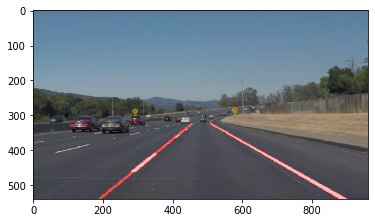

In [110]:
img = process_image(image[0])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidWhiteCurveOut.png", img) 

True

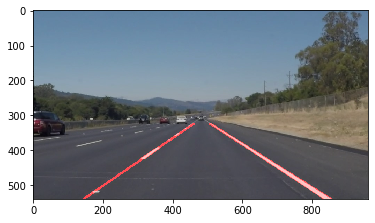

In [111]:
img = process_image(image[1])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidWhiteRightOut.png", img) 

True

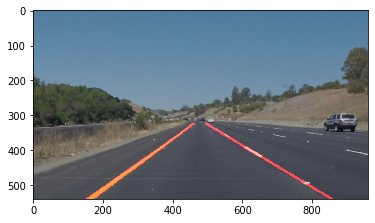

In [112]:
img = process_image(image[2])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidYellowCurveOut.png", img) 

True

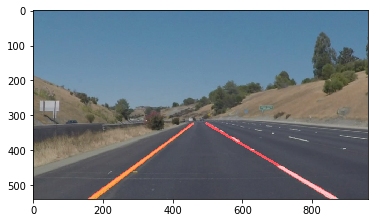

In [113]:
img = process_image(image[3])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidYellowCurve2Out.png", img) 

True

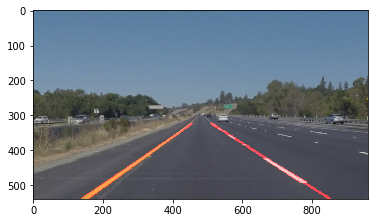

In [114]:
img = process_image(image[4])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidYellowLeftOut.png", img) 

True

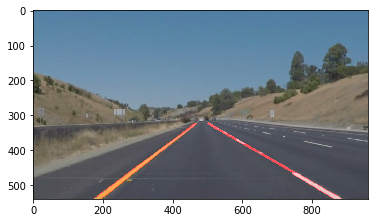

In [115]:
img = process_image(image[5])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/whiteCarLaneSwitchOut.png", img) 

t:   1%|▉                                                                    | 3/221 [00:00<00:07, 29.75it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4




t:  91%|█████████████████████████████████████████████████████████████▏     | 202/221 [00:08<00:01, 12.62it/s, now=None]


t:  73%|█████████████████████████████████████████████████                  | 162/221 [10:58<00:02, 24.32it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 10.4 s


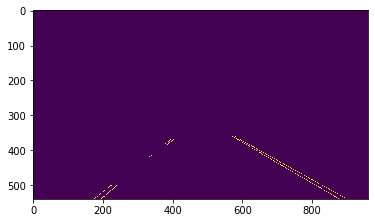

In [116]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|▍                                                                    | 4/681 [00:00<00:20, 32.76it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4




t:  30%|████████████████████▎                                              | 207/681 [00:08<00:20, 23.23it/s, now=None]


t:  59%|███████████████████████████████████████▊                           | 405/681 [00:16<00:11, 24.34it/s, now=None]


t:  89%|███████████████████████████████████████████████████████████▎       | 603/681 [00:25<00:03, 22.71it/s, now=None]


t:  73%|█████████████████████████████████████████████████                  | 162/221 [11:46<00:02, 24.32it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 29.1 s


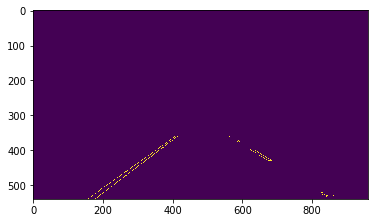

In [117]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)